In [1]:
import glob
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
path = "Datos"
 
Archivos = glob.glob(path + "/*.xlsx")
ListaExcel = []
 
for Archivo in Archivos:
    ListaExcel.append(pd.read_excel(Archivo))
 
sismos = pd.DataFrame() 
for excel in ListaExcel:
    sismos = sismos.append(
      excel, ignore_index=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_3160\2472829785.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sismos = sismos.append(


In [3]:
sismos.head()

,FECHA,HORA_UTC,LATITUD (grados),LONGITUD (grados),PROFUNDIDAD (Km),MAGNITUD Ml,MAGNITUD Mw,DEPARTAMENTO,MUNICIPIO,# FASES,RMS (Seg),GAP (grados),ERROR LATITUD (Km),ERROR LONGITUD (Km),ERROR PROFUNDIDAD (Km),ESTADO
0,1993-06-01,01:32:55,6.795,-73.052,150.1,2.9,NaN,SANTANDER,LOS_SANTOS,4,0.3,320.0,8.7,10.0,8.6,Revisado
1,1993-06-01,03:08:28,6.790,-73.053,152.5,3.0,NaN,SANTANDER,LOS_SANTOS,4,0.3,320.0,10.3,9.8,8.9,Revisado
2,1993-06-01,10:13:18,6.839,-73.105,152.1,2.9,NaN,SANTANDER,LOS_SANTOS,4,0.5,321.0,13.2,12.3,11.2,Revisado
3,1993-06-01,10:34:45,6.894,-73.171,150.0,2.9,NaN,SANTANDER,BETULIA,4,0.3,308.0,8.6,9.5,8.4,Revisado
4,1993-06-01,15:31:24,6.754,-73.058,150.0,4.4,NaN,SANTANDER,JORDAN,9,0.5,308.0,8.9,8.1,7.6,Revisado


In [4]:
sismos.dtypes

FECHA                      object
HORA_UTC                   object
LATITUD (grados)          float64
LONGITUD (grados)         float64
PROFUNDIDAD (Km)          float64
MAGNITUD Ml               float64
MAGNITUD Mw               float64
DEPARTAMENTO               object
MUNICIPIO                  object
# FASES                     int64
RMS (Seg)                 float64
GAP (grados)              float64
ERROR LATITUD (Km)        float64
ERROR LONGITUD (Km)       float64
ERROR PROFUNDIDAD (Km)    float64
ESTADO                     object
dtype: object

In [5]:
sismos["FechaCompleta"] = pd.to_datetime(sismos.FECHA+" "+ sismos.HORA_UTC)

In [8]:
Departamento = gpd.read_file('D:/Programación_Python/Python-ArcPy/Datos/MGN_DPTO_POLITICO.shp')

Departamento.DPTO_CNMBR = Departamento.DPTO_CNMBR.astype("category")
Departamento.DPTO_CNMBR = Departamento.DPTO_CNMBR.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
rename_dic = {"ARCHIPIELAGO DE SAN ANDRES, PROVIDENCIA Y SANTA CATALINA":"ARCHIPIELAGO DE SAN ANDRES. PROV. Y STA CATALINA"}
Departamento.DPTO_CNMBR = Departamento.DPTO_CNMBR.replace(rename_dic).astype("category")
sismos.DEPARTAMENTO = sismos.DEPARTAMENTO.astype("category")
sismos = pd.merge(sismos, Departamento[['DPTO_CNMBR',"DPTO_NAREA"]], left_on = 'DEPARTAMENTO', right_on='DPTO_CNMBR', how="left")

In [10]:
sismos_shape = gpd.GeoDataFrame(sismos,geometry = gpd.points_from_xy(sismos["LONGITUD (grados)"], sismos["LATITUD (grados)"]))
sismos_shape.crs = 'epsg:4326'

unidades_crono = gpd.read_file('D:/Programación_Python/Python-ArcPy/Datos/UnidaddesCrono.shp')
fallas = gpd.read_file('D:/Programación_Python/Python-ArcPy/Datos/Fallas.shp')
Volcanes = gpd.read_file('D:/Programación_Python/Python-ArcPy/Datos/Volcanes.shp')

unidades_crono = unidades_crono.to_crs("epsg:4326")
fallas = fallas.to_crs("epsg:4326")
Volcanes = Volcanes.to_crs("epsg:4326")



In [12]:
sismos = sismos_shape.sjoin(unidades_crono, how = "left")
sismos_geo = gpd.GeoSeries(sismos_shape.geometry)
sismos_fallas = fallas.sindex.nearest(sismos_geo, return_all=False,return_distance= True)
sismos_volcanes = Volcanes.sindex.nearest(sismos_geo, return_all=False, return_distance= True)

In [13]:
sismos["id_falla"] = sismos_fallas[0][1]
sismos["Disfalla"] = sismos_fallas[1]
sismos["id_volcan"] = sismos_volcanes[0][1]
sismos["Disvolcan"] = sismos_volcanes[1]

In [14]:
sismos = pd.merge(sismos, Volcanes, left_on = 'id_volcan', right_index=True, how="left")
sismos = pd.merge(sismos, fallas, left_on = 'id_falla', right_index=True, how="left")

In [15]:
sismos.NombreVolc.unique()

array(['Volcán San Diego', 'Volcán Paramillo de Santa Rosa',
       'Volcán Cumbal', 'Volcán Romeral', None, 'Volcán Nevado del Ruiz',
       'Volcán La Palma', 'Volcán Cerro Negro', 'Volcán Sotará',
       'Volcán Nevado del Huila', 'Volcán Guacharacos',
       'Volcán El Escondido', 'Volcán Azufral', 'Volcán Cerro Machín',
       'Volcán Galeras', 'Volcán Cerro Bravo', 'Volcán Chiles',
       'Maar de Yerbabuena', 'Volcán Las Ánimas', 'Volcán Morazurco',
       'Volcán Puracé', 'Volcán Cutunga', 'Volcán Nevado del Tolima',
       'Volcan Santa Leticia', 'Volcán Sibundoy',
       'Complejo Volcánico de Doña Juana', 'Volcán Laguna del Buey',
       'Volcán El Morro', 'Volcán El Pensil', 'Volcán Merenberg',
       'Volcán Petacas', 'Volcán Cerro Crespo',
       'Volcán Paramillo del Quindío', 'Volcán El Dorado',
       'Volcán Paramillo del Cisne', 'Volcán Nevado de Santa Isabel',
       'Volcán Shaka', 'Volcán Bordoncillo', 'Volcán Mujundinoy',
       'Volcán Campanero', 'Volcán Calamb

In [16]:
sismos["Año"] = sismos.FechaCompleta.dt.year
sismos["Mes"] = sismos.FechaCompleta.dt.month
sismos["Dia"] = sismos.FechaCompleta.dt.weekday
sismos["hora"] = sismos.FechaCompleta.dt.hour

In [17]:
sismos = sismos[(sismos.Año >=1994) &(sismos.Año <=2017)]

In [18]:
sismos["edad2"]=sismos.Edad.str.split('-', expand = True)[0] 
sismos.edad2 = sismos.edad2.str.replace("?","")



C:\Users\Usuario\AppData\Local\Temp\ipykernel_3160\3465048668.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  sismos.edad2 = sismos.edad2.str.replace("?","")


In [19]:
edades = {'Jurásico': 201.3,
'Cuaternario': 2.58,
'Ordovícico': 485,
'Paleoceno': 66,
'Jurásico Inferior': 163.5,
'Langhiano': 15.97,
'Valanginiano': 139.8,
'Jurásico Superior': 163.5,
'Aptiano': 121.4,
'Berriasiano': 145,
'Prídoli':423,
'Esténico': 1200,
'Triásico': 251.902,
'Eoceno': 56,
'Turoniano': 93.9,
'Plioceno': 5.33,
'Rupeliano': 33.9,
'Cretácico Inferior': 145,
'Cretácico Superior':100.5,
'Holoceno': 0.0117,
'Pleistoceno': 2.58,
'Cenomaniano':100.5,
'Cámbrico': 538.8,
'Albiano': 113,
'Mioceno': 23.03,
'Oligoceno': 33.9,
'Serravaliano': 13.82,
'Tortoniano': 11.63,
'Barremiano':129.4,
'Bartoniano': 41.2,
'Paleozoico': 358.9,
'Aptiano': 121.4,
'Campaniano': 83.6,
'Albiano': 113,
'Aquitaniano': 23.03,
'Devónico': 419.2,
'Devónico Medio': 393.3,
'Mesiniano': 7.246,
'Cenomaniano': 100.5,
'Pérmico': 298.9,
'Aquitaniano': 23.03,
'Thanetiano': 59.2,
'Maastrichtiano': 72.1,
'Burdigaliano':20.44, 
'Carbonífero':358.9,
'Pensilvánico': 318,
'Ordovícico Inferior':485.4,
'Lutetiano': 47.8,
'Jurásico Medio': 174.1,
'Triásico Superior':237}

In [20]:
def map_values(x):
    return edades.get(x, x)

sismos["EdadMillAños"] = sismos.edad2.apply(map_values)
    

In [21]:
columns_dict = {"LATITUD (grados)":"Latitud",
                "LONGITUD (grados)":"Longitud",
                "PROFUNDIDAD (Km)":"Profundidad",
                "MAGNITUD Ml":"Magnitud_ML",
                "DEPARTAMENTO":"Departamento",
                "MUNICIPIO":"Municipio",
                "# FASES":"Fases",
                "DPTO_NAREA":"Area_Departamento"
               }
sismos = sismos.rename(columns=columns_dict)

In [22]:
sismos = sismos.drop(columns=['FECHA','HORA_UTC','MAGNITUD Mw','RMS (Seg)', 'GAP (grados)','ERROR LATITUD (Km)', 'ERROR LONGITUD (Km)', 'ERROR PROFUNDIDAD (Km)',
       'ESTADO', 'DPTO_CNMBR','ERROR LATITUD (Km)', 'ERROR LONGITUD (Km)', 'ERROR PROFUNDIDAD (Km)', 'ESTADO','geometry_x','index_right', 'N_CartaCo', 'SHAPE_Leng_x', 'SHAPE_Area', 
       'id_falla','id_volcan','VolcanID','Latitud', 'Longitud', 'Comentario_y', 'URL','geometry_y','Tipo', 'Comentario', 'SHAPE_Leng_y','geometry','Comentario_x', 'edad2'])

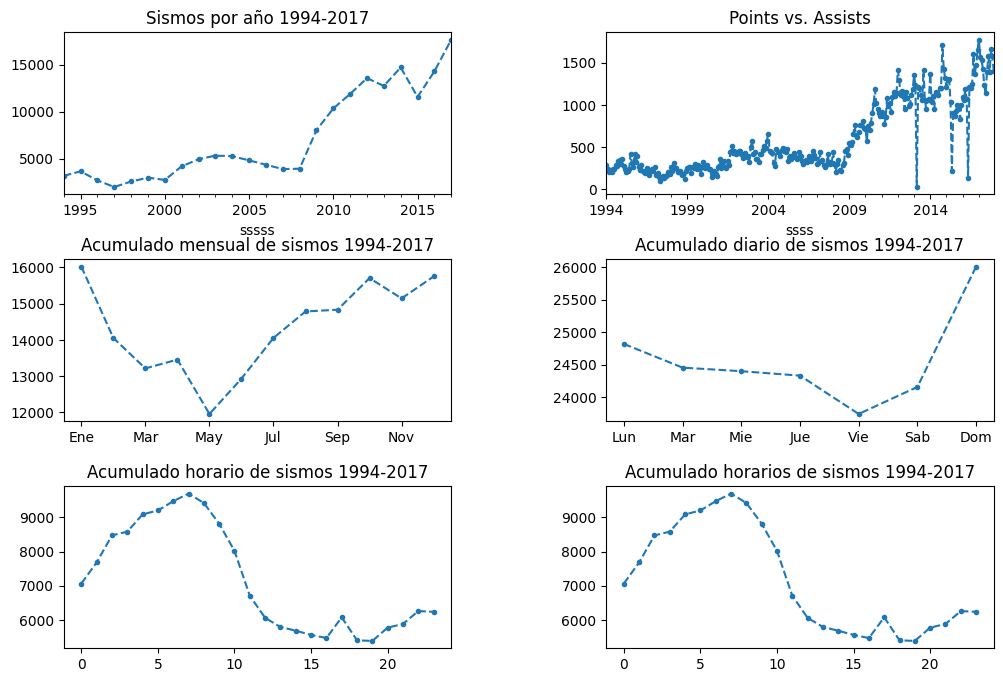

In [23]:
sismos_xmes = pd.to_datetime(sismos.FechaCompleta).dt.to_period(freq = 'M')
sismos_xmes = sismos_xmes.value_counts().sort_index()

sismos_xaño = pd.to_datetime(sismos.FechaCompleta).dt.to_period(freq = 'Y')
sismos_xaño = sismos_xaño.value_counts().sort_index()


sismosmes = sismos.Mes.value_counts().sort_index()
sismosmes.index = ['Ene','Feb','Mar','Abr','May','Jun', 'Jul','Ago','Sep','Oct','Nov','Dec']

sismosdia = sismos.Dia.value_counts().sort_index()
sismosdia.index = ['Lun','Mar','Mie','Jue','Vie','Sab','Dom']

sismoshora = sismos.hora.value_counts().sort_index()


fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))

sismos_xmes.plot(marker='.', ls = '--', title = 'Sismos por Mes 1994-2017', ax=ax2).set(title='Points vs. Assists', xlabel = "ssss")



sismos_xaño.plot(marker='.', ls = '--', title = 'Sismos por año 1994-2017', ax=ax1).set_xlabel("sssss")
sismosmes.plot(marker='.', ls = '--', title = 'Acumulado mensual de sismos 1994-2017', ax=ax3)
sismosdia.plot(marker='.', ls = '--', title = 'Acumulado diario de sismos 1994-2017', ax=ax4)
sismoshora.plot(marker='.', ls = '--', title = 'Acumulado horario de sismos 1994-2017', ax=ax5)
sismoshora.plot(marker='.', ls = '--', title = 'Acumulado horarios de sismos 1994-2017', ax=ax6)



plt.subplots_adjust(wspace=0.4,hspace=0.4)

In [34]:
sismos.head(1)

,Profundidad,Magnitud_ML,Departamento,Municipio,Fases,FechaCompleta,Area_Departamento,SimboloUC,Descripcio,Edad,...,Disfalla,Disvolcan,NombreVolc,AlturaSobr,NombreFall,Año,Mes,Dia,hora,EdadMillAños
1136,158.6,3.7,SANTANDER,CEPITA,8,1994-01-01 00:06:37,30561.514953,J-Pi,Granodioritas que varían de sienogranitos a to...,Jurásico,...,0.021758,2.335882,Volcán San Diego,850.0,Falla del Río Perchiquez,1994,1,5,0,201.3


In [33]:
sismos.isna().sum()

Profundidad              0
Magnitud_ML              0
Departamento             0
Municipio                0
Fases                    0
FechaCompleta            0
Area_Departamento        1
SimboloUC             8992
Descripcio            9005
Edad                  9005
UGIntegrad           91888
Disfalla                 0
Disvolcan                0
NombreVolc            7930
AlturaSobr               0
NombreFall           59232
Año                      0
Mes                      0
Dia                      0
hora                     0
EdadMillAños          9005
dtype: int64

In [36]:
sismos.isnull().sum()

AttributeError: 'DataFrame' object has no attribute 'isnone'

In [32]:
sismos.EdadMillAños.value_counts()

139.8      42652
145        31240
2.58       13717
201.3      11790
485        11754
163.5      11333
100.5       5813
93.9        5605
5.33        4335
113         2681
1200        2629
251.902     2267
66          2164
13.82       2001
33.9        1925
23.03       1754
41.2        1711
0.0117      1283
72.1        1065
538.8       1058
423          874
56           670
419.2        640
15.97        394
11.63        334
7.246        317
121.4        225
129.4        152
393.3        120
59.2         113
358.9         80
83.6          74
298.9         57
174.1         52
237           16
318           13
47.8           7
485.4          6
Pos            5
20.44          4
Name: EdadMillAños, dtype: int64

ValueError: could not convert string to float: 'Pos'

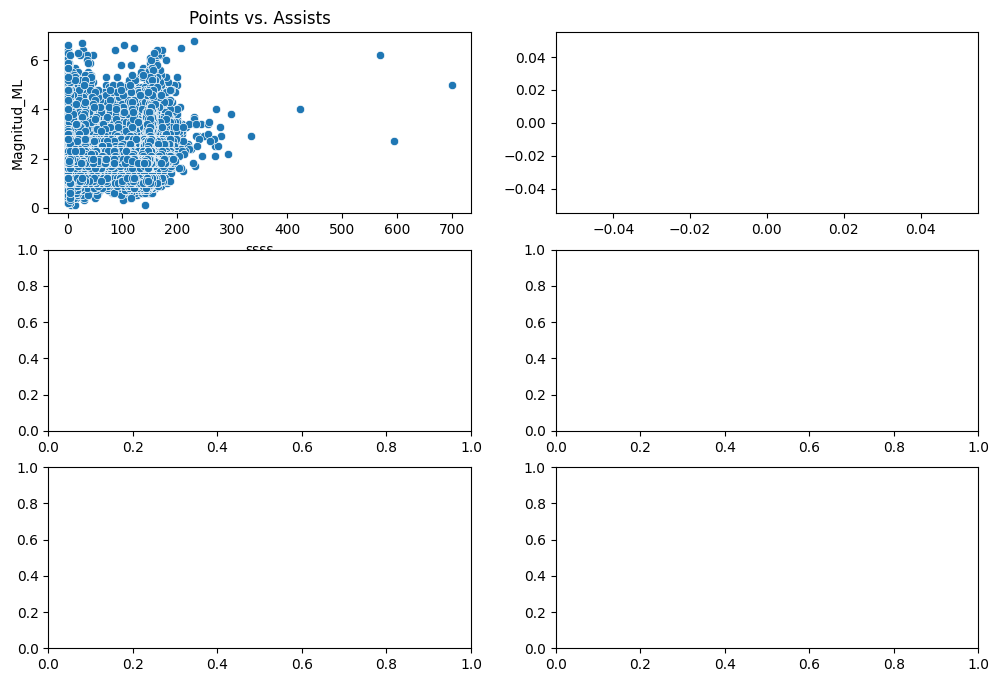

In [26]:


fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))

sns.scatterplot( data=sismos, x=sismos.Profundidad, y=sismos.Magnitud_ML, ax = ax1).set(title='Points vs. Assists', xlabel = "ssss")
sns.scatterplot( data=sismos, x=sismos.EdadMillAños, y=sismos.Magnitud_ML, ax = ax2).set(title='Points vs. Assists', xlabel = "ssss")






<AxesSubplot: xlabel='Año', ylabel='Mes'>

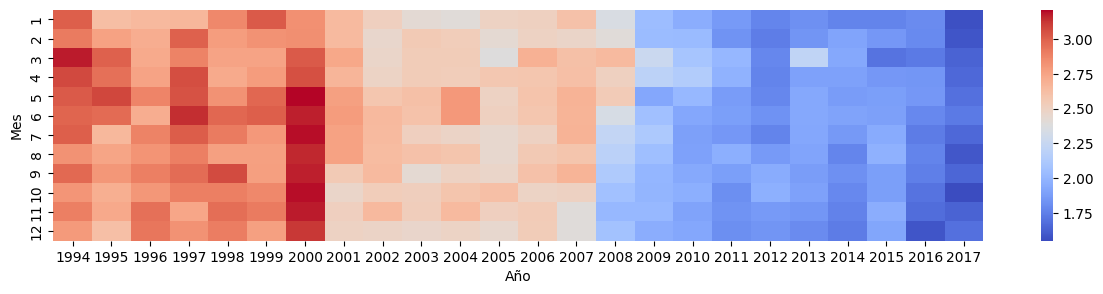

In [ ]:
pivoted_df = pd.pivot_table(data=sismos, index="Mes", columns="Año", values="Magnitud_ML")

plt.figure(figsize=(15, 3)) # We can set the size using matplotlib
sns.heatmap(pivoted_df, cmap="coolwarm") # cmap defines the color palette

In [ ]:
pivoted_df

Año,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Mes,,,,,,,,,,,,,,,,,,,,,
1,3.010690,2.623288,2.652124,2.666667,2.867954,3.018898,2.834891,2.641808,2.511429,2.425308,...,2.348993,2.041016,1.952162,1.862500,1.770085,1.820799,1.769752,1.765956,1.799177,1.564338
2,2.910204,2.762094,2.708974,3.004598,2.778404,2.825283,2.836328,2.646964,2.455607,2.553511,...,2.406040,2.031286,2.026215,1.834857,1.738936,1.839854,1.909971,1.850813,1.791149,1.586603
3,3.178641,3.004979,2.721127,2.886224,2.757051,2.755385,3.018841,2.732895,2.469869,2.538182,...,2.645588,2.266252,2.091247,2.004286,1.776518,2.214815,1.927125,1.703982,1.727647,1.638381
4,3.072642,2.952709,2.756075,3.063571,2.721176,2.786154,3.052759,2.673193,2.489716,2.539266,...,2.508136,2.193874,2.140851,1.981733,1.765948,1.896694,1.894555,1.849037,1.845131,1.656263
5,3.021569,3.079070,2.878199,3.046000,2.826877,2.984151,3.213136,2.766792,2.580476,2.610556,...,2.549570,1.925756,2.013850,1.870463,1.781818,1.928631,1.868261,1.881081,1.849265,1.688583
6,2.988477,2.971610,2.706599,3.147297,2.980788,3.007143,3.171849,2.788800,2.651622,2.600000,...,2.341126,2.060062,1.924360,1.885354,1.825708,1.927020,1.900616,1.893348,1.783802,1.724978
7,3.006198,2.658294,2.885156,3.015385,2.912808,2.800337,3.194444,2.760121,2.641432,2.515550,...,2.226977,2.118971,1.889286,1.854012,1.763944,1.924553,1.858274,1.938960,1.732836,1.654421
8,2.823630,2.750799,2.818534,2.900000,2.768519,2.768980,3.160513,2.762759,2.637176,2.603571,...,2.189399,2.051846,1.896537,1.960307,1.863611,1.908982,1.772492,1.974625,1.767708,1.593274
9,2.975801,2.804247,2.900000,2.960784,3.066286,2.771930,3.169811,2.556027,2.643915,2.432903,...,2.130392,2.002865,1.934479,1.884215,1.950051,1.877170,1.816444,1.882869,1.746101,1.649784


Index(['SANTANDER', 'ANTIOQUIA', 'CHOCO', 'VALLE DEL CAUCA', 'HUILA', 'BOYACA',
       'CUNDINAMARCA', 'NARINO', 'CESAR', 'META'],
      dtype='object')

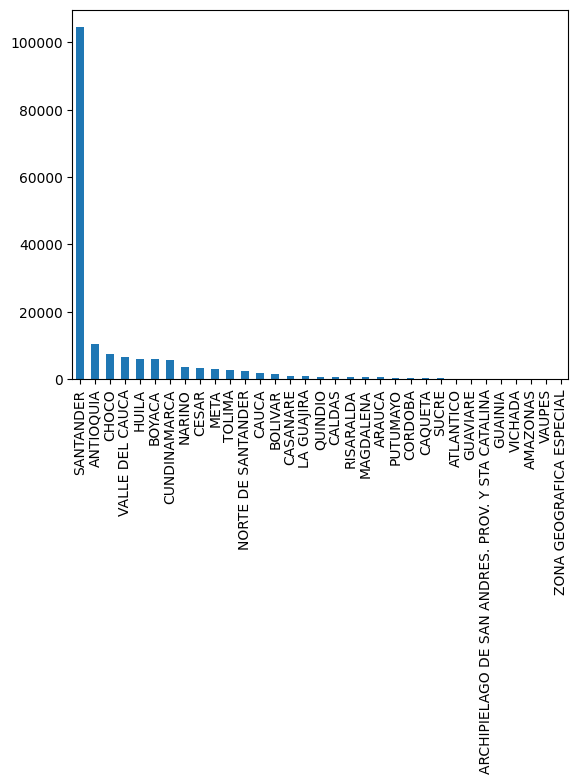

In [ ]:
SismosDpto  = sismos.Departamento.value_counts()
SismosDpto.plot.bar()
SismosDpto.head(10).index



sns.barplot(data=SismosDpto, x=SismosDpto.index, y=SismosDpto.values, ax=ax2).set(xticklabels=ticks)

In [ ]:
pd.DataFrame(SismosDpto)

,Departamento
SANTANDER,104480
ANTIOQUIA,10523
CHOCO,7374
VALLE DEL CAUCA,6567
HUILA,6093
BOYACA,5901
CUNDINAMARCA,5780
NARINO,3678
CESAR,3187
META,3070


In [ ]:
sismosdpto = sismos.groupby(["Departamento"])["Magnitud_ML"].max()

<AxesSubplot: xlabel='Departamento'>

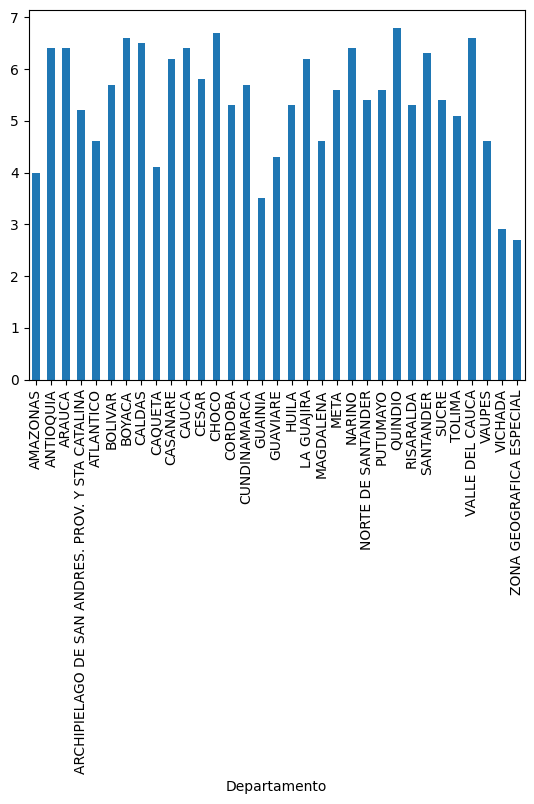

In [ ]:
sismosdpto.plot.bar()

In [ ]:
sismosaño = sismos.groupby(["Departamento", "Año"])["Magnitud_ML"].max()
sismosaño

Departamento              Año 
AMAZONAS                  1998    4.0
                          2012    3.2
ANTIOQUIA                 1994    6.4
                          1995    5.1
                          1996    5.4
                                 ... 
VICHADA                   1998    2.8
                          2010    2.9
                          2013    2.5
                          2014    2.5
ZONA GEOGRAFICA ESPECIAL  2004    2.7
Name: Magnitud_ML, Length: 650, dtype: float64

<AxesSubplot: xlabel='Departamento', ylabel='Año'>

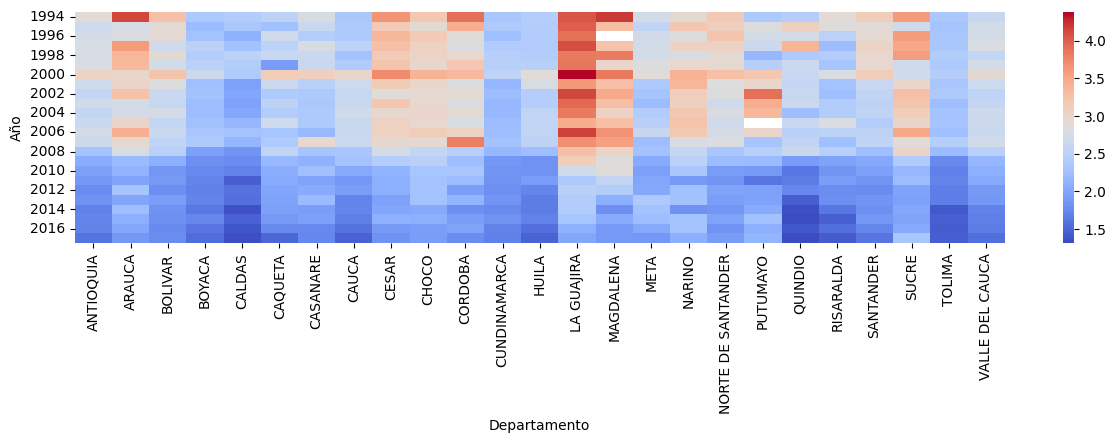

In [ ]:
pivoted_df2 = pd.pivot_table(data=sismos, index="Año", columns="Departamento", values="Magnitud_ML")
pivoted_df2 = pivoted_df2.drop(columns=['ARCHIPIELAGO DE SAN ANDRES. PROV. Y STA CATALINA', 'GUAINIA', 'VAUPES','VICHADA', 'ZONA GEOGRAFICA ESPECIAL', 'AMAZONAS', 'GUAVIARE', 'ATLANTICO'])

plt.figure(figsize=(15, 3)) # We can set the size using matplotlib
sns.heatmap(pivoted_df2, cmap="coolwarm") # cmap defines the color palet

In [ ]:
sismos

,Profundidad,Magnitud_ML,Departamento,Municipio,Fases,FechaCompleta,Area_Departamento,SimboloUC,Descripcio,Edad,UGIntegrad,Disfalla,Disvolcan,NombreVolc,AlturaSobr,NombreFall,Año,Mes,Dia,hora
1136,158.6,3.7,SANTANDER,CEPITA,8,1994-01-01 00:06:37,30561.514953,J-Pi,Granodioritas que varían de sienogranitos a to...,Jurásico,Granito de Pescadero,0.021758,2.335882,Volcán San Diego,850.0,Falla del Río Perchiquez,1994,1,5,0
1137,166.6,4.1,SANTANDER,GUACA,12,1994-01-01 08:17:30,30561.514953,J-Pi,Granodioritas que varían de sienogranitos a to...,Jurásico,Granito de Pescadero,0.017281,2.387977,Volcán San Diego,850.0,Falla del Río Perchiquez,1994,1,5,8
1138,35.2,3.6,ANTIOQUIA,MURINDO,13,1994-01-01 20:25:54,62808.629597,Q-al,Depósitos aluviales y de llanuras aluviales,Cuaternario,None,0.143934,2.120475,Volcán Romeral,3858.0,None,1994,1,5,20
1139,150.0,3.0,SANTANDER,SAN_ANDRES,12,1994-01-02 01:55:17,30561.514953,OS1-Mbg,"Filitas, esquistos, cuarcitas, pizarras, metac...",Ordovícico-Llandovery,Formación Silgará,0.010589,2.364454,Volcán San Diego,850.0,None,1994,1,6,1
1140,34.3,2.9,ANTIOQUIA,URRAO,13,1994-01-02 03:25:27,62808.629597,E1E2-VCm,Basaltos; brechas; aglomerados y tobas interca...,Paleoceno-Eoceno,Complejo Santa Cecilia-La Equis,0.066595,1.610929,Volcán Romeral,3858.0,None,1994,1,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175908,140.1,1.8,SANTANDER,LOS_SANTOS,13,2017-12-31 10:27:49,30561.514953,b2b6-Sm,"Shales con yeso, cherts, calizas y arenitas.",Valanginiano-Albiano,None,0.029086,2.135963,Volcán San Diego,850.0,Falla de Aratoca,2017,12,6,10
175909,141.4,1.8,SANTANDER,LOS_SANTOS,10,2017-12-31 14:19:03,30561.514953,b2b6-Sm,"Shales con yeso, cherts, calizas y arenitas.",Valanginiano-Albiano,None,0.038211,2.123106,Volcán San Diego,850.0,Falla de Suárez,2017,12,6,14
175910,144.8,1.8,SANTANDER,LOS_SANTOS,10,2017-12-31 14:35:51,30561.514953,b2b6-Sm,"Shales con yeso, cherts, calizas y arenitas.",Valanginiano-Albiano,None,0.038302,2.119558,Volcán San Diego,850.0,Falla de Suárez,2017,12,6,14
175911,140.0,1.8,SANTANDER,ZAPATOCA,7,2017-12-31 15:23:12,30561.514953,b2b6-Sm,"Shales con yeso, cherts, calizas y arenitas.",Valanginiano-Albiano,None,0.030152,2.116932,Volcán San Diego,850.0,Falla de Suárez,2017,12,6,15
